In [43]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

dftel = pd.read_csv("My Drive/10X/Week1/clean_df.csv")
dftel = dftel[dftel['Handset Type'] != 'undefined']
dftel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18618 entries, 0 to 19496
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        18618 non-null  int64  
 1   Bearer Id                         18618 non-null  int64  
 2   Start                             18618 non-null  object 
 3   End                               18618 non-null  object 
 4   Dur (s)                           18618 non-null  int64  
 5   IMSI                              18618 non-null  int64  
 6   MSISDN/Number                     18618 non-null  int64  
 7   IMEI                              18618 non-null  int64  
 8   Last Location Name                18618 non-null  object 
 9   Avg RTT DL (ms)                   18618 non-null  float64
 10  Avg RTT UL (ms)                   18618 non-null  float64
 11  Avg Bearer TP DL (kbps)           18618 non-null  int64  
 12  Avg 

In [45]:
dftel.columns.tolist()

['Unnamed: 0',
 'Bearer Id',
 'Start',
 'End',
 'Dur (s)',
 'IMSI',
 'MSISDN/Number',
 'IMEI',
 'Last Location Name',
 'Avg RTT DL (ms)',
 'Avg RTT UL (ms)',
 'Avg Bearer TP DL (kbps)',
 'Avg Bearer TP UL (kbps)',
 'TCP DL Retrans. Vol (Bytes)',
 'TCP UL Retrans. Vol (Bytes)',
 'DL TP < 50 Kbps (%)',
 '50 Kbps < DL TP < 250 Kbps (%)',
 '250 Kbps < DL TP < 1 Mbps (%)',
 'DL TP > 1 Mbps (%)',
 'UL TP < 10 Kbps (%)',
 '10 Kbps < UL TP < 50 Kbps (%)',
 '50 Kbps < UL TP < 300 Kbps (%)',
 'UL TP > 300 Kbps (%)',
 'HTTP DL (Bytes)',
 'HTTP UL (Bytes)',
 'Activity Duration DL (ms)',
 'Activity Duration UL (ms)',
 'Handset Manufacturer',
 'Handset Type',
 'Nb of sec with Vol DL < 6250B',
 'Nb of sec with Vol UL < 1250B',
 'Social Media DL (Bytes)',
 'Social Media UL (Bytes)',
 'Google DL (Bytes)',
 'Google UL (Bytes)',
 'Email DL (Bytes)',
 'Email UL (Bytes)',
 'Youtube DL (Bytes)',
 'Youtube UL (Bytes)',
 'Netflix DL (Bytes)',
 'Netflix UL (Bytes)',
 'Gaming DL (Bytes)',
 'Gaming UL (Bytes)',


In [46]:
# top 10 customers per sessions frequency
user_engagement_df = dftel[['MSISDN/Number', 'Bearer Id', 'Dur (s)', 'Total Data Volume (Bytes)']]
user_engagement_df = user_engagement_df.groupby('MSISDN/Number').agg({'Bearer Id': 'count', 'Dur (s)': 'sum', 
                                              'Total Data Volume (Bytes)': 'sum'})
user_engagement_df = user_engagement_df.rename(
    columns={'Bearer Id': 'xDR Sessions'})

user_engagement_df.sort_values(by=['xDR Sessions'], ascending=False).head(10)

,xDR Sessions,Dur (s),Total Data Volume (Bytes)
MSISDN/Number,,,
33614892860,10,5944484,5.463771e+09
33681557919,8,3833147,3.298240e+09
33627080969,7,2915342,3.322626e+09
33698792269,7,3139699,4.188045e+09
33675588018,6,2227781,2.308362e+09
33668836891,6,1900270,2.775216e+09
33667585643,5,1717136,2.114523e+09
33660214653,5,1878896,2.321835e+09
33652163825,5,1611060,3.117259e+09


In [47]:
# top 10 customer per session duration
user_engagement_df.sort_values(by=['Dur (s)'], ascending=False).head(10)

,xDR Sessions,Dur (s),Total Data Volume (Bytes)
MSISDN/Number,,,
33614892860,10,5944484,5.463771e+09
33681557919,8,3833147,3.298240e+09
33698792269,7,3139699,4.188045e+09
33627080969,7,2915342,3.322626e+09
33659219748,4,2420252,1.778790e+09
33675588018,6,2227781,2.308362e+09
33658263267,5,2059836,2.289240e+09
33760206871,5,1997203,3.571401e+09
33760662234,4,1986223,2.602409e+09


In [48]:
user_engagement_df.sort_values(by=['Total Data Volume (Bytes)'], ascending=False).head(10)

,xDR Sessions,Dur (s),Total Data Volume (Bytes)
MSISDN/Number,,,
33614892860,10,5944484,5.463771e+09
33698792269,7,3139699,4.188045e+09
33760206871,5,1997203,3.571401e+09
33627080969,7,2915342,3.322626e+09
33681557919,8,3833147,3.298240e+09
33652163825,5,1611060,3.117259e+09
33659546392,5,1723890,3.088931e+09
33666318144,4,1155093,2.791143e+09
33668836891,6,1900270,2.775216e+09


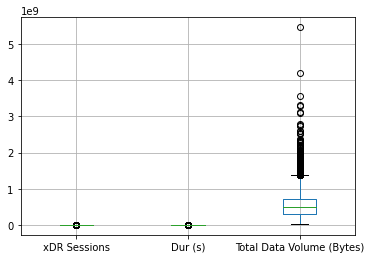

In [70]:
df_normal = user_engagement_df.copy()
#df_normal.dtypes
df_normal.boxplot()

In [72]:
# remove dataframe
def fix_outlier(datf):
  for col in datf.columns:
    Q1 = datf[col].quantile(0.25)
    Q3 = datf[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    datf[col] = datf[col].clip(lower, upper)
  return datf

fix_outlier(df_normal)
df_normal.head()
#df_normal.boxplot()

,xDR Sessions,Dur (s),Total Data Volume (Bytes)
MSISDN/Number,,,
33601008617,1.0,18555.0,871832580.0
33601047438,1.0,31778.0,250441008.0
33601062786,1.0,10532.0,769716233.0
33601070798,1.0,12842.0,692598460.0
33601072539,1.0,32737.0,373706286.0


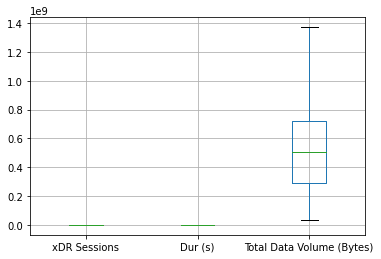

In [76]:
df_normal.boxplot()

In [77]:
# normalize columns
def normalizer(datf):
  for col in datf.columns:
    datf[col] = datf[col] /datf[col].abs().max()

normalizer(df_normal)
df_normal.tail()

,xDR Sessions,Dur (s),Total Data Volume (Bytes)
MSISDN/Number,,,
33789649244,1.0,0.099759,0.482836
33789650572,1.0,0.463920,0.299480
33789781631,1.0,0.373713,0.197680
33789914536,1.0,0.463915,0.267117
33789996170,1.0,0.047305,0.521438
